In [1]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as sklm
import sklearn.model_selection as skcv
import ml_uncertainty as plu

In [2]:
xdata = np.array([[4.00],
[4.20],
[4.30],
[4.47],
[4.58],
[4.60],
[4.61],
[4.82],
[5.05],
[5.24],
[5.43],
[5.58],
[5.82],
[5.91],
[5.92],
[6.03],
[6.32],
[6.45],
[6.67],
[6.68],
[6.91],
[7.04],
[7.09],
[7.35],
[7.49],
[7.62],
[7.81],
[7.94]])


In [3]:
yfull = np.array([[3.70,3.53,4.12,5.03,],
[2.96,4.69,6.44,7.36,],
[4.69,3.68,5.86,5.70,],
[4.28,4.22,5.32,6.33,],
[4.86,5.27,5.61,5.57,],
[4.77,4.61,5.38,4.91,],
[4.74,4.45,6.34,5.71,],
[4.76,4.40,6.51,5.62,],
[5.01,5.52,5.85,6.92,],
[5.59,5.81,5.86,7.98,],
[5.17,4.67,5.58,8.38,],
[6.02,6.04,5.70,6.87,],
[6.68,5.94,5.78,8.10,],
[6.91,5.97,5.68,7.80,],
[6.14,5.74,6.30,7.65,],
[5.67,5.78,4.97,8.98,],
[6.89,6.41,6.40,8.08,],
[6.57,6.46,6.44,8.43,],
[7.34,6.31,6.14,8.55,],
[6.62,5.98,5.78,9.17,],
[7.22,6.59,5.99,8.95,],
[8.05,6.85,6.78,10.92,],
[7.11,7.29,6.19,9.74,],
[6.43,7.40,6.45,9.39,],
[7.02,7.14,7.34,10.13,],
[7.27,7.37,6.12,10.04,],
[7.29,7.07,5.65,10.91,],
[8.29,8.39,6.57,11.78,]])

ydata = yfull[:,0]

In [4]:
regr = sklm.LinearRegression()
cv = skcv.KFold(n_splits=6,shuffle=True)

$$Y = X\beta$$
$$\beta = (X^TX)^{-1}X^TY$$

In [5]:
regr.fit(xdata,ydata)
ypred = regr.predict(xdata)
y_cv = skcv.cross_val_predict(regr,xdata,y=ydata,cv=cv)


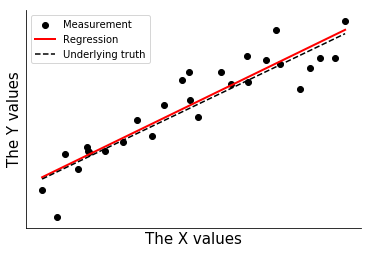

In [6]:
#with plt.xkcd():
fig,ax = plt.subplots(1,1)

p1 = plt.scatter(xdata,ydata,color='k',label='Measurement')
p2 = plt.plot(xdata,ypred,color='r',lw=2,label='Regression')
p3 = plt.plot(xdata,xdata,color='k',ls='--',label='Underlying truth')

handles, labels = ax.get_legend_handles_labels()

plt.legend([handles[i] for i in [2,0,1]],[labels[i] for i in [2,0,1]])
ax.set_xlabel('The X values',size=15)
ax.set_ylabel('The Y values',size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel

t = 1

$$ Y_{new} = X_{new}\beta + \epsilon$$

$$ \delta Y_{new} = t(0.95,n-2)\Bigg\{
                          \frac{Y^TY-\beta^TX^TY}{n-2}\Bigg[X_{new}(X^TX)^{-1}X_{new}^T+1\Bigg]
                          \Bigg\}^{1/2}$$

In [7]:
#Create the linear regression X matrix
xmatrix_first = np.ones_like(xdata) #Constant term
xmatrix = np.concatenate((xmatrix_first,xdata),axis=1) #Add in the linear term

cov = np.dot(xmatrix.T,xmatrix) #Covariance matrix
icov = np.linalg.inv(cov) #Inverse covariance matrix
xty = np.dot(xmatrix.T,ydata[:,np.newaxis,]) #XTy

beta = np.dot(icov,xty) #Coefficients

dof = len(xmatrix_first) - 2 #Degrees of freedom
tdist = sp.stats.t(dof) #T distribution
#T premultiplier, only one standard deviation because n is large. Squared because of how pred_unc is defined below
tmult = tdist.ppf(0.95) ** 2 

sse = (np.dot(ydata.T,ydata) - np.dot(ypred.T,ydata))/(dof) #mean squared error

var_premult = tmult * sse 

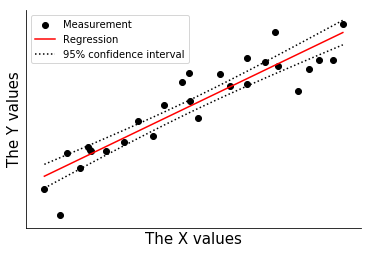

In [8]:
yl = []
yu = []
for row in xmatrix:

    yp = np.dot(row,beta)
    pred_unc = np.sqrt(var_premult*(np.dot(np.dot(row,icov),row.T)))

    yl += [yp - pred_unc]
    yu += [yp + pred_unc]

    #print(pred)

    #print(pred,pred_lower,pred_upper)
lower = np.concatenate(yl)
upper = np.concatenate(yu)

yunc = np.concatenate((yl,yu),axis=1)

fig,ax = plt.subplots()

ax.plot(xdata,ypred,color='r',label='Regression')
ax.plot(xdata,yunc,ls=':',color='k',label='95% confidence interval')
ax.scatter(xdata,ydata,color='k',label='Measurement')

handles, labels = ax.get_legend_handles_labels()

ax.legend([handles[i] for i in [3,0,1]],[labels[i] for i in [3,0,1]])

ax.set_xlabel('The X values',size=15)
ax.set_ylabel('The Y values',size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.legend()

In [9]:
residual,err,mse = plu.get_residual_stats(ydata,ypred)
residual_cv,err_cv,msecv = plu.get_residual_stats(ydata,y_cv)

num_train = len(xdata)

pseudo_dof = num_train * (1 - np.sqrt(mse/msecv))
bootstrap_weight = np.sqrt(1 - pseudo_dof/num_train)

print(bootstrap_weight)

residual_weighted = residual / bootstrap_weight

0.9373050564598135


In [10]:
samples = 5

residual_boot,boot_indices = plu.bootstrap_data(residual_weighted,samples=samples)
residual_boot = np.squeeze(residual_boot)

boot_data = (residual_boot + ypred).T #boot_data now has the new Y values with shuffled residuals

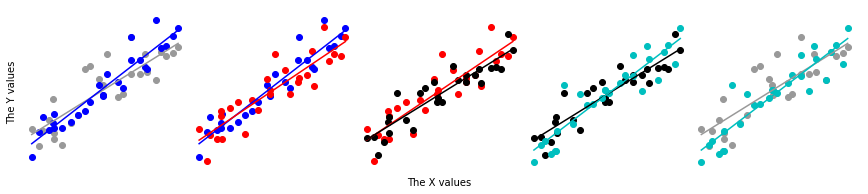

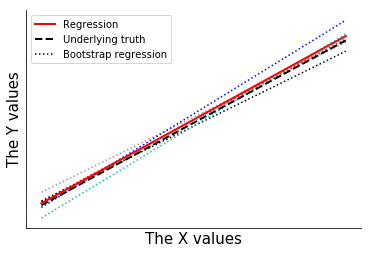

In [11]:
fig,axes = plt.subplots(1,samples,figsize=(3*samples,3),sharey=True,
                        gridspec_kw=dict(wspace=0),subplot_kw=dict(frameon=False))
fig2,ax2=plt.subplots(1,1)

colors = '0.6','b','r','k','c'
ax2.plot(xdata,ypred,color='r',lw=2,zorder=100,label='Regression')
ax2.plot(xdata,xdata,color='k',ls='--',lw=2,zorder=99,label='Underlying truth')

ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_xlabel('The X values',size=15)
ax2.set_ylabel('The Y values',size=15)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(True)

for plot_num,(color,yboot) in enumerate(zip(colors,boot_data.T)):
    
    yb = yboot[:,np.newaxis]
    
    #fig,ax = plt.subplots(1,1)
    regr.fit(xdata,yb)
    ypb = regr.predict(xdata)
    
    #print('{},{}'.format(plot_num-1,plot_num+1))
    
    for ax in axes[[plot_num-1,plot_num]]:
        ax.scatter(xdata,yb,color=color)
        ax.plot(xdata,ypb,color=color)
        ax.set_xticks([])
    if color=='k':
        ax2.plot(xdata,ypb,color=color,ls=':',label='Bootstrap regression')
    else:
        ax2.plot(xdata,ypb,color=color,ls=':')

ax = axes[0]
ax.set_yticks([])
ax.set_ylabel('The Y values')
ax = axes[2]
ax.set_xlabel('The X values')


ax2.legend()


In [12]:
samples = 1000

lbt_out = plu.bootstrap(xdata=xdata,ydata=np.squeeze(ydata),
                        PLS_model=regr,cv_object=cv,samples=samples)
rcv,ecv,msecv,cpb,cpt = lbt_out

No transform function, skipping scores


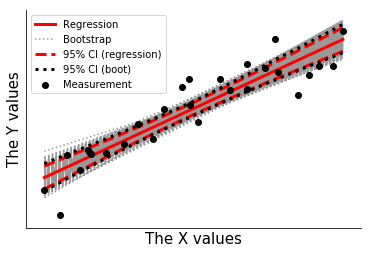

In [13]:
fig2,ax2=plt.subplots(1,1)

for ypb in cpb.T:
    ax2.plot(xdata,ypb,color='0.6',ls=':',zorder=0)


intervals = np.array([np.percentile(cpb,97.5,axis=1), np.percentile(cpb,2.5,axis=1)])

ax2.plot(xdata,ypred,color='r',lw=3,label='Regression',zorder=3)
ax2.plot(xdata,yunc,ls='--',color='r',lw=3,label='95% CI (regression)',zorder=3)
ax2.plot(xdata,ypb,color='0.6',ls=':',label='Bootstrap',zorder=-1)

ax2.plot(xdata,intervals.T,ls=':',color='k',lw=3,label='95% CI (boot)',zorder=4)

ax2.scatter(xdata,ydata,color='k',label='Measurement',zorder=5)

ax2.set_xlabel('The X values',size=15)
ax2.set_ylabel('The Y values',size=15)

ax2.set_xticks([])
ax2.set_yticks([])


ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#ax2.legend()

handles, labels = ax2.get_legend_handles_labels()

ax2.legend([handles[i] for i in [0,3,1,4,6]],[labels[i] for i in [0,3,1,4,6]])

t = 1

In [19]:
(yunc-intervals[::-1].T)/np.array()

array([[ 0.05517332, -0.07119444],
       [ 0.04859221, -0.07239128],
       [ 0.04367514, -0.07150052],
       [ 0.03899877, -0.06750441],
       [ 0.03571097, -0.06393831],
       [ 0.03378349, -0.06408298],
       [ 0.03268463, -0.0641478 ],
       [ 0.0320849 , -0.05605043],
       [ 0.02810861, -0.05347956],
       [ 0.02607774, -0.04879635],
       [ 0.02441205, -0.04826689],
       [ 0.02056211, -0.04383436],
       [ 0.02974614, -0.03918142],
       [ 0.03018288, -0.03818425],
       [ 0.02962705, -0.0386364 ],
       [ 0.03222273, -0.03462113],
       [ 0.02910533, -0.04496108],
       [ 0.02638041, -0.04974504],
       [ 0.02177912, -0.06107879],
       [ 0.0221806 , -0.06052196],
       [ 0.02193362, -0.07153582],
       [ 0.02760917, -0.07829497],
       [ 0.02603908, -0.08102588],
       [ 0.03044203, -0.07441155],
       [ 0.03120508, -0.08133688],
       [ 0.03661673, -0.08065974],
       [ 0.04128581, -0.09088041],
       [ 0.04174182, -0.09245988]])

In [20]:
yunc

array([[3.71767288, 4.37933362],
       [3.94497224, 4.55768536],
       [4.05829695, 4.6471862 ],
       [4.25035031, 4.79993627],
       [4.37415123, 4.89924345],
       [4.39661578, 4.91734401],
       [4.40784259, 4.92639976],
       [4.64267299, 5.11750301],
       [4.89739123, 5.32928352],
       [5.10528299, 5.50676031],
       [5.31028956, 5.68712228],
       [5.46970686, 5.83194329],
       [5.71961028, 6.0688212 ],
       [5.81155514, 6.15941933],
       [5.82171001, 6.16954701],
       [5.93260462, 6.28176051],
       [6.21808602, 6.58447319],
       [6.34309684, 6.72313558],
       [6.55113315, 6.96131548],
       [6.56049628, 6.97223491],
       [6.77396972, 7.22526023],
       [6.89325358, 7.36964958],
       [6.93890941, 7.42540652],
       [7.17465814, 7.71700421],
       [7.30064121, 7.87497691],
       [7.41714376, 8.02214758],
       [7.58672167, 8.2379382 ],
       [7.70234924, 8.38598384]])

In [22]:
intervals.T

array([[4.45052806, 3.66249957],
       [4.63007664, 3.89638003],
       [4.71868672, 4.01462181],
       [4.86744068, 4.21135154],
       [4.96318176, 4.33844026],
       [4.98142699, 4.36283229],
       [4.99054756, 4.37515796],
       [5.17355344, 4.61058809],
       [5.38276308, 4.86928262],
       [5.55555665, 5.07920525],
       [5.73538917, 5.28587751],
       [5.87577766, 5.44914475],
       [6.10800262, 5.68986414],
       [6.19760358, 5.78137226],
       [6.20818341, 5.79208296],
       [6.31638164, 5.90038189],
       [6.62943427, 6.18898069],
       [6.77288062, 6.31671643],
       [7.02239427, 6.52935402],
       [7.03275687, 6.53831568],
       [7.29679604, 6.75203609],
       [7.44794454, 6.86564441],
       [7.5064324 , 6.91287033],
       [7.79141576, 7.14421611],
       [7.95631379, 7.26943614],
       [8.10280731, 7.38052702],
       [8.32881861, 7.54543586],
       [8.47844373, 7.66060742]])

In [23]:
samples = 1000

residual_boot,boot_indices = plu.bootstrap_data(residual_weighted,samples=samples)
residual_boot = np.squeeze(residual_boot)

boot_data = (residual_boot + ypred).T 
#boot_data now has the new Y values with shuffled residuals

In [25]:
boot_data.T.shape

(1000, 28)

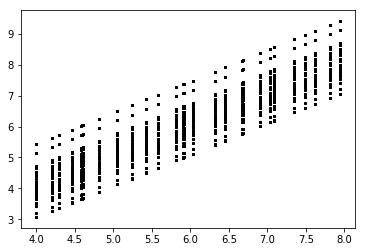

In [30]:
for row in boot_data.T:
    plt.scatter(xdata,row,s=1,color='k')

In [31]:
boot_data.T.std(axis=0)

array([0.56608812, 0.54231047, 0.55901546, 0.5459315 , 0.54492867,
       0.53924983, 0.55297044, 0.58156724, 0.56166797, 0.54072041,
       0.56269115, 0.55057405, 0.53003111, 0.53496418, 0.54839079,
       0.54699388, 0.57489016, 0.56853126, 0.56764148, 0.55301693,
       0.5538737 , 0.56604773, 0.56193022, 0.55383506, 0.55399726,
       0.55522476, 0.5622612 , 0.55939004])